In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import data
import embedding
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ridge_utils.ridge import bootstrap_ridge, ridge_corr, ridge_corr_pred, zs

/jet/home/tkubo/.conda/envs/lab3_214/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("../../../shared/data/raw_text.pkl", "rb") as file:
    rawdata = pickle.load(file)

In [3]:
del rawdata['dialogue1']
del rawdata['dialogue2']
del rawdata['dialogue3']
del rawdata['dialogue4']
del rawdata['dialogue5']
del rawdata['dialogue6']
del rawdata['myfirstdaywiththeyankees']
del rawdata['onlyonewaytofindout']

In [4]:
full_stories = list(rawdata.keys())
train_stories, test_stories = train_test_split(full_stories, test_size = 0.3, random_state = 1)

print(len(train_stories))
print(len(test_stories))

model_train_stories, model_eval_stories = train_test_split(train_stories, test_size = 0.3, random_state = 1)

print(len(model_train_stories))
print(len(model_eval_stories))

70
31
49
21


In [5]:
train_sentences = data.split_based_on_flags(rawdata, model_train_stories, 0.7, 30, 100)
eval_sentences = data.split_based_on_flags(rawdata, model_eval_stories, 0.7, 30, 100)

In [6]:
train_embeddings_pretrained = embedding.auto_embeddings_pretrained(rawdata, train_stories, delay = [1, 2, 3, 4])
test_embeddings_pretrained = embedding.auto_embeddings_pretrained(rawdata, test_stories, delay = [1, 2, 3, 4])

/ocean/projects/mth240012p/tkubo/lab3.3/code/embedding.py:121: RuntimeWarning: invalid value encountered in divide
  embed = np.where(count[:, np.newaxis] != 0, embed / count[:, np.newaxis], 0)


In [7]:
train_embeddings_pretrained["sweetaspie"].shape

(157, 3072)

In [8]:
train_embeddings_pretrained["sweetaspie"]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09192264,  0.05405292,  0.5245644 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.84244442,  0.67342337,  1.29079143, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.06091618,  0.85063944,  0.56473993, ..., -3.9323937 ,
        -1.02809708, -0.04597635],
       [ 0.1660989 ,  0.00973914,  0.17960642, ..., -1.65909537,
         0.99025003, -0.45046745],
       [ 1.9074395 ,  0.44803807,  0.30594625, ...,  0.34662354,
        -0.13527446,  0.10497561]])

In [9]:

def load_measurement_data_by_subject(story_key):
    """Load measurement data and return it separated by subject."""
    base_dir = "../../../shared/data"
    subject2_file = os.path.join(base_dir, "subject2", f"{story_key}.npy")
    subject3_file = os.path.join(base_dir, "subject3", f"{story_key}.npy")
    
    subject2_data = None
    subject3_data = None
    
    if os.path.exists(subject2_file):
        subject2_data = np.load(subject2_file)
        print(f"Loaded subject2 data for '{story_key}'")
    
    if os.path.exists(subject3_file):
        subject3_data = np.load(subject3_file)
        print(f"Loaded subject3 data for '{story_key}'")
    
    return subject2_data, subject3_data

# Load first 6 keys for train and first 2 keys for test
train_keys = list(train_embeddings_pretrained.keys())
test_keys = list(test_embeddings_pretrained.keys())

# Initialize lists to store data for each subject
subject2_train_rows = []
subject3_train_rows = []
subject2_test_rows = []
subject3_test_rows = []

# Process training data
print("\nProcessing training data:")
for story_key in train_keys:
    subject2_data, subject3_data = load_measurement_data_by_subject(story_key)
    
    if subject2_data is not None:
        subject2_train_rows.append({
            'story_key': story_key,
            'measurement_data': subject2_data
        })
    
    if subject3_data is not None:
        subject3_train_rows.append({
            'story_key': story_key,
            'measurement_data': subject3_data
        })

# Process test data
print("\nProcessing test data:")
for story_key in test_keys:
    subject2_data, subject3_data = load_measurement_data_by_subject(story_key)
    
    if subject2_data is not None:
        subject2_test_rows.append({
            'story_key': story_key,
            'measurement_data': subject2_data
        })
    
    if subject3_data is not None:
        subject3_test_rows.append({
            'story_key': story_key,
            'measurement_data': subject3_data
        })

# Create DataFrames for each subject
train_resp_subject2 = pd.DataFrame(subject2_train_rows).set_index('story_key')
train_resp_subject3 = pd.DataFrame(subject3_train_rows).set_index('story_key')
test_resp_subject2 = pd.DataFrame(subject2_test_rows).set_index('story_key')
test_resp_subject3 = pd.DataFrame(subject3_test_rows).set_index('story_key')

# Print summary
print("\nDataset Summary:")
print(f"Subject 2 training stories: {len(train_resp_subject2)}")
print(f"Subject 3 training stories: {len(train_resp_subject3)}")
print(f"Subject 2 test stories: {len(test_resp_subject2)}")
print(f"Subject 3 test stories: {len(test_resp_subject3)}")

print("\nTraining stories for Subject 2:", list(train_resp_subject2.index))
print("Training stories for Subject 3:", list(train_resp_subject3.index))
print("\nTest stories for Subject 2:", list(test_resp_subject2.index))
print("Test stories for Subject 3:", list(test_resp_subject3.index))

# Print shapes of measurement data
print("\nMeasurement data shapes:")
if len(train_resp_subject2) > 0:
    print(f"Subject 2 training shape: {train_resp_subject2.iloc[0]['measurement_data'].shape}")
if len(train_resp_subject3) > 0:
    print(f"Subject 3 training shape: {train_resp_subject3.iloc[0]['measurement_data'].shape}")


Processing training data:


Loaded subject2 data for 'googlingstrangersandkentuckybluegrass'


Loaded subject3 data for 'googlingstrangersandkentuckybluegrass'


Loaded subject2 data for 'alternateithicatom'


Loaded subject3 data for 'alternateithicatom'


Loaded subject2 data for 'thumbsup'


Loaded subject3 data for 'thumbsup'


Loaded subject2 data for 'igrewupinthewestborobaptistchurch'


Loaded subject3 data for 'igrewupinthewestborobaptistchurch'


Loaded subject2 data for 'penpal'


Loaded subject3 data for 'penpal'


Loaded subject2 data for 'wildwomenanddancingqueens'


Loaded subject3 data for 'wildwomenanddancingqueens'


Loaded subject2 data for 'canplanetearthfeedtenbillionpeoplepart3'


Loaded subject3 data for 'canplanetearthfeedtenbillionpeoplepart3'


Loaded subject2 data for 'souls'


Loaded subject3 data for 'souls'


Loaded subject2 data for 'threemonths'


Loaded subject3 data for 'threemonths'


Loaded subject2 data for 'christmas1940'


Loaded subject3 data for 'christmas1940'


Loaded subject2 data for 'canplanetearthfeedtenbillionpeoplepart1'


Loaded subject3 data for 'canplanetearthfeedtenbillionpeoplepart1'


Loaded subject2 data for 'firetestforlove'


Loaded subject3 data for 'firetestforlove'


Loaded subject2 data for 'eyespy'


Loaded subject3 data for 'eyespy'


Loaded subject2 data for 'naked'


Loaded subject3 data for 'naked'


Loaded subject2 data for 'canadageeseandddp'


Loaded subject3 data for 'canadageeseandddp'


Loaded subject2 data for 'theinterview'


Loaded subject3 data for 'theinterview'


Loaded subject2 data for 'thecurse'


Loaded subject3 data for 'thecurse'


Loaded subject2 data for 'swimmingwithastronauts'


Loaded subject3 data for 'swimmingwithastronauts'


Loaded subject2 data for 'adollshouse'


Loaded subject3 data for 'adollshouse'


Loaded subject2 data for 'afatherscover'


Loaded subject3 data for 'afatherscover'


Loaded subject2 data for 'howtodraw'


Loaded subject3 data for 'howtodraw'


Loaded subject2 data for 'life'


Loaded subject3 data for 'life'


Loaded subject2 data for 'whenmothersbullyback'


Loaded subject3 data for 'whenmothersbullyback'


Loaded subject2 data for 'gpsformylostidentity'


Loaded subject3 data for 'gpsformylostidentity'


Loaded subject2 data for 'bluehope'


Loaded subject3 data for 'bluehope'


Loaded subject2 data for 'lawsthatchokecreativity'


Loaded subject3 data for 'lawsthatchokecreativity'


Loaded subject2 data for 'singlewomanseekingmanwich'


Loaded subject3 data for 'singlewomanseekingmanwich'


Loaded subject2 data for 'buck'


Loaded subject3 data for 'buck'


Loaded subject2 data for 'thesurprisingthingilearnedsailingsoloaroundtheworld'


Loaded subject3 data for 'thesurprisingthingilearnedsailingsoloaroundtheworld'


Loaded subject2 data for 'seedpotatoesofleningrad'


Loaded subject3 data for 'seedpotatoesofleningrad'


Loaded subject2 data for 'thetiniestbouquet'


Loaded subject3 data for 'thetiniestbouquet'


Loaded subject2 data for 'indianapolis'


Loaded subject3 data for 'indianapolis'


Loaded subject2 data for 'mybackseatviewofagreatromance'


Loaded subject3 data for 'mybackseatviewofagreatromance'


Loaded subject2 data for 'gangstersandcookies'


Loaded subject3 data for 'gangstersandcookies'


Loaded subject2 data for 'theshower'


Loaded subject3 data for 'theshower'


Loaded subject2 data for 'becomingindian'


Loaded subject3 data for 'becomingindian'


Loaded subject2 data for 'cocoonoflove'


Loaded subject3 data for 'cocoonoflove'


Loaded subject2 data for 'adventuresinsayingyes'


Loaded subject3 data for 'adventuresinsayingyes'


Loaded subject2 data for 'sweetaspie'


Loaded subject3 data for 'sweetaspie'


Loaded subject2 data for 'stagefright'


Loaded subject3 data for 'stagefright'


Loaded subject2 data for 'treasureisland'


Loaded subject3 data for 'treasureisland'


Loaded subject2 data for 'onapproachtopluto'


Loaded subject3 data for 'onapproachtopluto'


Loaded subject2 data for 'theadvancedbeginner'


Loaded subject3 data for 'theadvancedbeginner'


Loaded subject2 data for 'undertheinfluence'


Loaded subject3 data for 'undertheinfluence'


Loaded subject2 data for 'shoppinginchina'


Loaded subject3 data for 'shoppinginchina'


Loaded subject2 data for 'notontheusualtour'


Loaded subject3 data for 'notontheusualtour'


Loaded subject2 data for 'kiksuya'


Loaded subject3 data for 'kiksuya'


Loaded subject2 data for 'legacy'


Loaded subject3 data for 'legacy'


Loaded subject2 data for 'food'


Loaded subject3 data for 'food'


Loaded subject2 data for 'haveyoumethimyet'


Loaded subject3 data for 'haveyoumethimyet'


Loaded subject2 data for 'mayorofthefreaks'


Loaded subject3 data for 'mayorofthefreaks'


Loaded subject2 data for 'avatar'


Loaded subject3 data for 'avatar'


Loaded subject2 data for 'thepostmanalwayscalls'


Loaded subject3 data for 'thepostmanalwayscalls'


Loaded subject2 data for 'canplanetearthfeedtenbillionpeoplepart2'


Loaded subject3 data for 'canplanetearthfeedtenbillionpeoplepart2'


Loaded subject2 data for 'goldiethegoldfish'


Loaded subject3 data for 'goldiethegoldfish'


Loaded subject2 data for 'odetostepfather'


Loaded subject3 data for 'odetostepfather'


Loaded subject2 data for 'superheroesjustforeachother'


Loaded subject3 data for 'superheroesjustforeachother'


Loaded subject2 data for 'jugglingandjesus'


Loaded subject3 data for 'jugglingandjesus'


Loaded subject2 data for 'listo'


Loaded subject3 data for 'listo'


Loaded subject2 data for 'quietfire'


Loaded subject3 data for 'quietfire'


Loaded subject2 data for 'thatthingonmyarm'


Loaded subject3 data for 'thatthingonmyarm'


Loaded subject2 data for 'againstthewind'


Loaded subject3 data for 'againstthewind'


Loaded subject2 data for 'leavingbaghdad'


Loaded subject3 data for 'leavingbaghdad'


Loaded subject2 data for 'wheretheressmoke'


Loaded subject3 data for 'wheretheressmoke'


Loaded subject2 data for 'golfclubbing'


Loaded subject3 data for 'golfclubbing'


Loaded subject2 data for 'birthofanation'


Loaded subject3 data for 'birthofanation'


Loaded subject2 data for 'hangtime'


Loaded subject3 data for 'hangtime'


Loaded subject2 data for 'thesecrettomarriage'


Loaded subject3 data for 'thesecrettomarriage'


Loaded subject2 data for 'stumblinginthedark'


Loaded subject3 data for 'stumblinginthedark'


Loaded subject2 data for 'exorcism'


Loaded subject3 data for 'exorcism'

Processing test data:


Loaded subject2 data for 'backsideofthestorm'


Loaded subject3 data for 'backsideofthestorm'


Loaded subject2 data for 'escapingfromadirediagnosis'


Loaded subject3 data for 'escapingfromadirediagnosis'


Loaded subject2 data for 'tetris'


Loaded subject3 data for 'tetris'


Loaded subject2 data for 'sloth'


Loaded subject3 data for 'sloth'


Loaded subject2 data for 'thefreedomridersandme'


Loaded subject3 data for 'thefreedomridersandme'


Loaded subject2 data for 'findingmyownrescuer'


Loaded subject3 data for 'findingmyownrescuer'


Loaded subject2 data for 'fromboyhoodtofatherhood'


Loaded subject3 data for 'fromboyhoodtofatherhood'


Loaded subject2 data for 'myfathershands'


Loaded subject3 data for 'myfathershands'


Loaded subject2 data for 'learninghumanityfromdogs'


Loaded subject3 data for 'learninghumanityfromdogs'


Loaded subject2 data for 'theclosetthatateeverything'


Loaded subject3 data for 'theclosetthatateeverything'


Loaded subject2 data for 'lifereimagined'


Loaded subject3 data for 'lifereimagined'


Loaded subject2 data for 'vixenandtheussr'


Loaded subject3 data for 'vixenandtheussr'


Loaded subject2 data for 'breakingupintheageofgoogle'


Loaded subject3 data for 'breakingupintheageofgoogle'


Loaded subject2 data for 'marryamanwholoveshismother'


Loaded subject3 data for 'marryamanwholoveshismother'


Loaded subject2 data for 'thetriangleshirtwaistconnection'


Loaded subject3 data for 'thetriangleshirtwaistconnection'


Loaded subject2 data for 'goingthelibertyway'


Loaded subject3 data for 'goingthelibertyway'


Loaded subject2 data for 'lifeanddeathontheoregontrail'


Loaded subject3 data for 'lifeanddeathontheoregontrail'


Loaded subject2 data for 'cautioneating'


Loaded subject3 data for 'cautioneating'


Loaded subject2 data for 'metsmagic'


Loaded subject3 data for 'metsmagic'


Loaded subject2 data for 'whyimustspeakoutaboutclimatechange'


Loaded subject3 data for 'whyimustspeakoutaboutclimatechange'


Loaded subject2 data for 'waitingtogo'


Loaded subject3 data for 'waitingtogo'


Loaded subject2 data for 'forgettingfear'


Loaded subject3 data for 'forgettingfear'


Loaded subject2 data for 'afearstrippedbare'


Loaded subject3 data for 'afearstrippedbare'


Loaded subject2 data for 'inamoment'


Loaded subject3 data for 'inamoment'


Loaded subject2 data for 'itsabox'


Loaded subject3 data for 'itsabox'


Loaded subject2 data for 'catfishingstrangerstofindmyself'


Loaded subject3 data for 'catfishingstrangerstofindmyself'


Loaded subject2 data for 'ifthishaircouldtalk'


Loaded subject3 data for 'ifthishaircouldtalk'


Loaded subject2 data for 'beneaththemushroomcloud'


Loaded subject3 data for 'beneaththemushroomcloud'


Loaded subject2 data for 'tildeath'


Loaded subject3 data for 'tildeath'


Loaded subject2 data for 'reachingoutbetweenthebars'


Loaded subject3 data for 'reachingoutbetweenthebars'


Loaded subject2 data for 'comingofageondeathrow'


Loaded subject3 data for 'comingofageondeathrow'

Dataset Summary:
Subject 2 training stories: 70
Subject 3 training stories: 70
Subject 2 test stories: 31
Subject 3 test stories: 31

Training stories for Subject 2: ['googlingstrangersandkentuckybluegrass', 'alternateithicatom', 'thumbsup', 'igrewupinthewestborobaptistchurch', 'penpal', 'wildwomenanddancingqueens', 'canplanetearthfeedtenbillionpeoplepart3', 'souls', 'threemonths', 'christmas1940', 'canplanetearthfeedtenbillionpeoplepart1', 'firetestforlove', 'eyespy', 'naked', 'canadageeseandddp', 'theinterview', 'thecurse', 'swimmingwithastronauts', 'adollshouse', 'afatherscover', 'howtodraw', 'life', 'whenmothersbullyback', 'gpsformylostidentity', 'bluehope', 'lawsthatchokecreativity', 'singlewomanseekingmanwich', 'buck', 'thesurprisingthingilearnedsailingsoloaroundtheworld', 'seedpotatoesofleningrad', 'thetiniestbouquet', 'indianapolis', 'mybackseatviewofagreatromance', 'gangstersandcookies', 'theshower', 'becomingindian', 'cocoonof


==================== Analyzing subject2 ====================

Evaluating BERT embedding for subject2

Number of stories - Train: 70, Test: 31


Data dimensions:
Training: 24503 timepoints × 3072 features → 94251 voxels
Testing:  10283 timepoints × 3072 features → 94251 voxels

Running cross-validation...


CV mean CC: 0.0182 (±0.0009)

Training final model...



Per-story performance:
Story 1: mean CC = 0.0108 ± 0.0110
Story 2: mean CC = 0.0140 ± 0.0121
Story 3: mean CC = 0.0142 ± 0.0136
Story 4: mean CC = 0.0121 ± 0.0123
Story 5: mean CC = 0.0139 ± 0.0102
Story 6: mean CC = 0.0133 ± 0.0152
Story 7: mean CC = 0.0119 ± 0.0104
Story 8: mean CC = 0.0168 ± 0.0150
Story 9: mean CC = 0.0137 ± 0.0121
Story 10: mean CC = 0.0184 ± 0.0129
Story 11: mean CC = 0.0180 ± 0.0151
Story 12: mean CC = 0.0173 ± 0.0154
Story 13: mean CC = 0.0125 ± 0.0099
Story 14: mean CC = 0.0144 ± 0.0129
Story 15: mean CC = 0.0172 ± 0.0152
Story 16: mean CC = 0.0197 ± 0.0202
Story 17: mean CC = 0.0147 ± 0.0142
Story 18: mean CC = 0.0154 ± 0.0129
Story 19: mean CC = 0.0182 ± 0.0148
Story 20: mean CC = 0.0150 ± 0.0120
Story 21: mean CC = 0.0217 ± 0.0198
Story 22: mean CC = 0.0172 ± 0.0159
Story 23: mean CC = 0.0145 ± 0.0126
Story 24: mean CC = 0.0144 ± 0.0132
Story 25: mean CC = 0.0154 ± 0.0146
Story 26: mean CC = 0.0178 ± 0.0127
Story 27: mean CC = 0.0166 ± 0.0148
Story 28: mea

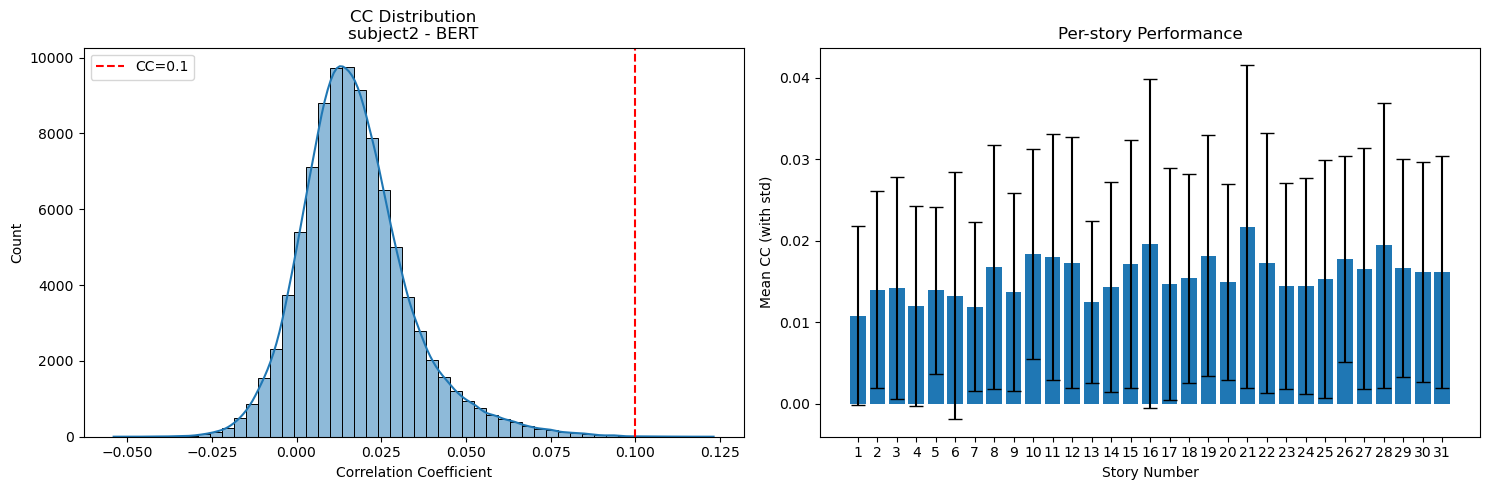


Results Summary:
Mean CC: 0.0174
Median CC: 0.0157
Top 1% CC: 0.0682
Top 5% CC: 0.0471
Voxels with CC > 0.1: 0.0%

==================== Analyzing subject3 ====================

Evaluating BERT embedding for subject3

Number of stories - Train: 70, Test: 31


Data dimensions:
Training: 24503 timepoints × 3072 features → 95556 voxels
Testing:  10283 timepoints × 3072 features → 95556 voxels

Running cross-validation...


CV mean CC: 0.0248 (±0.0005)

Training final model...



Per-story performance:
Story 1: mean CC = 0.0139 ± 0.0116
Story 2: mean CC = 0.0151 ± 0.0123
Story 3: mean CC = 0.0196 ± 0.0174
Story 4: mean CC = 0.0169 ± 0.0119
Story 5: mean CC = 0.0361 ± 0.0252
Story 6: mean CC = 0.0227 ± 0.0184
Story 7: mean CC = 0.0158 ± 0.0102
Story 8: mean CC = 0.0236 ± 0.0192
Story 9: mean CC = 0.0297 ± 0.0223
Story 10: mean CC = 0.0240 ± 0.0245
Story 11: mean CC = 0.0151 ± 0.0117
Story 12: mean CC = 0.0147 ± 0.0134
Story 13: mean CC = 0.0249 ± 0.0196
Story 14: mean CC = 0.0328 ± 0.0273
Story 15: mean CC = 0.0186 ± 0.0149
Story 16: mean CC = 0.0181 ± 0.0165
Story 17: mean CC = 0.0146 ± 0.0109
Story 18: mean CC = 0.0142 ± 0.0160
Story 19: mean CC = 0.0228 ± 0.0180
Story 20: mean CC = 0.0203 ± 0.0208
Story 21: mean CC = 0.0172 ± 0.0138
Story 22: mean CC = 0.0230 ± 0.0220
Story 23: mean CC = 0.0181 ± 0.0141
Story 24: mean CC = 0.0159 ± 0.0152
Story 25: mean CC = 0.0194 ± 0.0161
Story 26: mean CC = 0.0259 ± 0.0203
Story 27: mean CC = 0.0222 ± 0.0171
Story 28: mea

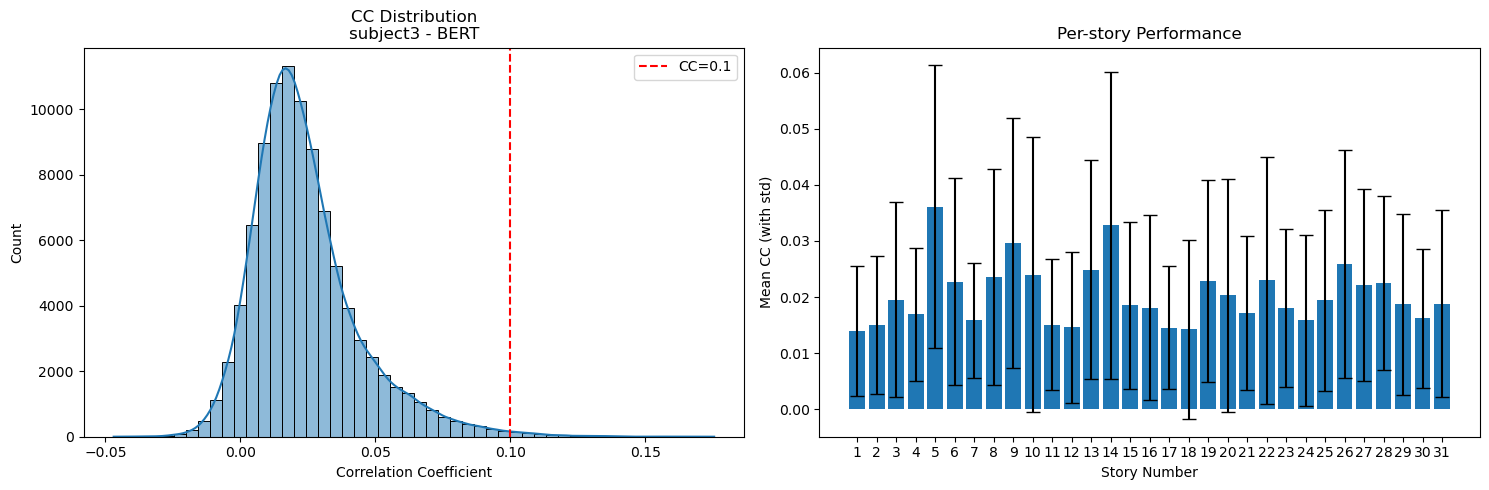


Results Summary:
Mean CC: 0.0242
Median CC: 0.0206
Top 1% CC: 0.0910
Top 5% CC: 0.0637
Voxels with CC > 0.1: 0.6%

=== Final Cross-subject Comparison ===

BERT:
subject2:
  Mean CC: 0.0174
  Voxels > 0.1: 0.0%
subject3:
  Mean CC: 0.0242
  Voxels > 0.1: 0.6%


In [10]:

# Create results directory
os.makedirs('../results', exist_ok=True)

# Create figs directory
os.makedirs('../figs', exist_ok=True)

# Constants
ALPHAS = np.logspace(1, 3, 3)  # [10, 100, 1000]
NBOOTS = 3
CHUNKLEN = 10
CC_THRESHOLD = 0.1  # Updated threshold from 0.2 to 0.1

def evaluate_embedding(train_embed, test_embed, train_resp, test_resp, embed_name, subject_name):
    """Efficient evaluation with focused output."""
    print(f"\n{'='*50}")
    print(f"Evaluating {embed_name} embedding for {subject_name}")
    
    # Data preparation
    train_keys = sorted(set(train_embed.keys()) & set(train_resp.index))
    test_keys = sorted(set(test_embed.keys()) & set(test_resp.index))
    
    print(f"\nNumber of stories - Train: {len(train_keys)}, Test: {len(test_keys)}")
    
    X_train_list, y_train_list = [], []
    X_test_dict, y_test_dict = {}, {}
    
    # Prepare training data
    for key in train_keys:
        embed = train_embed[key]
        resp = train_resp.loc[key, 'measurement_data']
        min_len = min(embed.shape[0], resp.shape[0])
        X_train_list.append(embed[:min_len])
        y_train_list.append(resp[:min_len])
    
    # Prepare test data
    for key in test_keys:
        embed = test_embed[key]
        resp = test_resp.loc[key, 'measurement_data']
        min_len = min(embed.shape[0], resp.shape[0])
        X_test_dict[key] = embed[:min_len]
        y_test_dict[key] = resp[:min_len]
    
    X_train = np.vstack(X_train_list)
    y_train = np.vstack(y_train_list)
    X_test = np.vstack(list(X_test_dict.values()))
    y_test = np.vstack(list(y_test_dict.values()))
    
    print(f"Data dimensions:")
    print(f"Training: {X_train.shape[0]} timepoints × {X_train.shape[1]} features → {y_train.shape[1]} voxels")
    print(f"Testing:  {X_test.shape[0]} timepoints × {X_test.shape[1]} features → {y_test.shape[1]} voxels")
    
    # Cross-validation
    n_splits = 3
    chunk_size = len(X_train) // n_splits
    cv_scores = []
    
    print("\nRunning cross-validation...")
    for i in range(n_splits):
        val_start = i * chunk_size
        val_end = (i + 1) * chunk_size
        
        X_val = X_train[val_start:val_end]
        y_val = y_train[val_start:val_end]
        X_train_cv = np.vstack([X_train[:val_start], X_train[val_end:]])
        y_train_cv = np.vstack([y_train[:val_start], y_train[val_end:]])
        
        wt_cv, corrs_cv, _, _, _ = bootstrap_ridge(
            X_train_cv, y_train_cv, X_val, y_val,
            alphas=ALPHAS, nboots=NBOOTS, chunklen=CHUNKLEN,
            nchunks=3, corrmin=CC_THRESHOLD, normalpha=True
        )
        cv_scores.append(np.mean(corrs_cv))
    
    print(f"CV mean CC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
    
    # Final model training
    print("\nTraining final model...")
    wt, corrs, valphas, allRcorrs, _ = bootstrap_ridge(
        X_train, y_train, X_test, y_test,
        alphas=ALPHAS, nboots=NBOOTS, chunklen=CHUNKLEN,
        nchunks=3, corrmin=CC_THRESHOLD, normalpha=True
    )
    
    # Per-story analysis
    story_performances = {}
    story_boundaries = np.cumsum([0] + [len(X_test_dict[k]) for k in test_keys])
    
    print("\nPer-story performance:")
    for i, key in enumerate(test_keys):
        story_corrs = corrs[story_boundaries[i]:story_boundaries[i+1]]
        story_performances[key] = {
            'mean_cc': np.nanmean(story_corrs),
            'median_cc': np.nanmedian(story_corrs),
            'std_cc': np.nanstd(story_corrs),
            'n_voxels': len(story_corrs),
            'correlations': story_corrs
        }
        print(f"Story {i+1}: mean CC = {story_performances[key]['mean_cc']:.4f} ± {story_performances[key]['std_cc']:.4f}")
    
    # Compute metrics
    metrics = {
        'mean_cc': np.nanmean(corrs),
        'median_cc': np.nanmedian(corrs),
        'top_1_percentile': np.nanpercentile(corrs, 99),
        'top_5_percentile': np.nanpercentile(corrs, 95),
        'correlations': corrs,
        'cv_scores': cv_scores,
        'story_performances': story_performances,
        'voxels_above_threshold': np.mean(corrs > CC_THRESHOLD) * 100
    }
    
    # Save model
    model_data = {
        'weights': wt,
        'best_alphas': valphas,
        'metrics': metrics,
        'training_shapes': {'X': X_train.shape, 'y': y_train.shape}
    }
    
    with open(f'../results/ridge_model_{subject_name}_{embed_name}.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # CC Distribution
    sns.histplot(corrs[~np.isnan(corrs)], bins=50, kde=True, ax=ax1)
    ax1.axvline(x=CC_THRESHOLD, color='r', linestyle='--', label=f'CC={CC_THRESHOLD}')
    ax1.set_title(f'CC Distribution\n{subject_name} - {embed_name}')
    ax1.set_xlabel('Correlation Coefficient')
    ax1.legend()
    
    # Story Performance with numerical indices
    story_means = [perf['mean_cc'] for perf in story_performances.values()]
    story_stds = [perf['std_cc'] for perf in story_performances.values()]
    x_pos = np.arange(1, len(story_means) + 1)
    
    ax2.bar(x_pos, story_means, yerr=story_stds, capsize=5)
    ax2.set_title('Per-story Performance')
    ax2.set_xlabel('Story Number')
    ax2.set_ylabel('Mean CC (with std)')
    ax2.set_xticks(x_pos)
    
    plt.tight_layout()
    
    # Save figure as PNG in ../figs directory
    fig.savefig(os.path.join('../figs', f"{subject_name}_{embed_name}.png"), dpi=300)
    
    # Display figure
    plt.show()
    
    # Print final results
    print("\nResults Summary:")
    print(f"Mean CC: {metrics['mean_cc']:.4f}")
    print(f"Median CC: {metrics['median_cc']:.4f}")
    print(f"Top 1% CC: {metrics['top_1_percentile']:.4f}")
    print(f"Top 5% CC: {metrics['top_5_percentile']:.4f}")
    print(f"Voxels with CC > {CC_THRESHOLD}: {metrics['voxels_above_threshold']:.1f}%")
    
    return metrics

# Main execution
subjects_to_analyze = {
    'subject2': (train_resp_subject2, test_resp_subject2),
    'subject3': (train_resp_subject3, test_resp_subject3)
}

embedding_pairs = {
    'BERT': (train_embeddings_pretrained, test_embeddings_pretrained)
}

# Run analysis
all_results = {}
for subject_name, (train_resp, test_resp) in subjects_to_analyze.items():
    print(f"\n{'='*20} Analyzing {subject_name} {'='*20}")
    
    subject_results = {}
    for embed_name, (train_embed, test_embed) in embedding_pairs.items():
        subject_results[embed_name] = evaluate_embedding(
            train_embed, test_embed,
            train_resp, test_resp,
            embed_name, subject_name
        )
    
    all_results[subject_name] = subject_results

# Final cross-subject comparison
print("\n=== Final Cross-subject Comparison ===")
for embed_name in embedding_pairs:
    print(f"\n{embed_name}:")
    for subject_name in subjects_to_analyze:
        metrics = all_results[subject_name][embed_name]
        print(f"{subject_name}:")
        print(f"  Mean CC: {metrics['mean_cc']:.4f}")
        print(f"  Voxels > {CC_THRESHOLD}: {metrics['voxels_above_threshold']:.1f}%")